# **MACHINE LEARNING SALARY PREDICTION**

## **Data Exploration**

**Load Dataset**

In [1]:
import pandas as pd

df = pd.read_csv("Salary_Data.csv")

**Little Inspection**

In [2]:
df.isna().sum() # checking for missing values
df.shape        # 6704 rows and 6 columns
df.dtypes       # checking the data type of each variable
df.describe()   # summary statistics

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


## **Data Preprocessing**

### Handling Missing Values

*Imputing numeric values with the median*

In [3]:
median_age = df["Age"].median()
df["Age"] = df["Age"].fillna(median_age)

median_exp = df["Years of Experience"].median()
df["Years of Experience"] = df["Years of Experience"].fillna(median_exp)

median_salary = df["Salary"].median()
df["Salary"] = df["Salary"].fillna(median_salary)

df.isna().sum() # Successfully handling of missing values in the numeric columns

Age                    0
Gender                 2
Education Level        3
Job Title              2
Years of Experience    0
Salary                 0
dtype: int64

*Imputing missing categorical values with the mode*

In [4]:
print(df["Gender"].mode()) #The mode is Male, so missing instances will be replaced by "Male" 
df["Gender"] = df["Gender"].astype(str) # Converting object to a string
df["Gender"] = df["Gender"].replace("nan", "Male")


print(df["Education Level"].mode()) # The mode for educational level is "Bachelor's Degree"
df["Education Level"] = df["Education Level"].astype(str) # Converting object to a string
df["Education Level"] = df["Education Level"].replace({"nan" :"Bachelor's Degree", # we still need to tidy up the values a bit for consistency
                                                      "Master's": "Master's Degree",
                                                      "Bachelor's": "Bachelor's Degree",
                                                      "phD": "PhD"})

print(df["Job Title"].mode()) # The mode for the Job Title column is "Software Engineer"
df["Job Title"] = df["Job Title"].astype(str) # Converting object to a string
df["Job Title"] = df["Job Title"].replace("nan", "Software Engineer")

df.isna().sum() # Successfully handled all missing values for the entire dataset

0    Male
Name: Gender, dtype: object
0    Bachelor's Degree
Name: Education Level, dtype: object
0    Software Engineer
Name: Job Title, dtype: object


Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

### Categorical and Numerical Variables

In [5]:
categorical_features = ["Gender", "Education Level", "Job Title"]
numerical_features = ["Age", "Years of Experience"] # This should not include the target variable

### Building Preprocessing Transformer

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

### Creating a Pipeline (*preprocessing and model*)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([("preprocessor", preprocessor),
                     ("model", RandomForestRegressor(random_state=23))])

### Define Features and Target 

In [8]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

### Cross-validation with Pipeline

In [9]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf = KFold(n_splits=10, shuffle=True, random_state=23)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring="r2", error_score="raise")

print("Cross-validation R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std Dev:", np.std(scores))

Cross-validation R² scores: [0.9762805  0.97272472 0.98519224 0.97474393 0.97339982 0.9766526
 0.97867642 0.97856673 0.97311504 0.98208522]
Mean R²: 0.9771437202835862
Std Dev: 0.0038741590408529433


## **Feature Importance**

In [10]:
pipeline.fit(X, y)

# Get feature names from the ColumnTransformer
one_hot_encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
one_hot_encoder_features = one_hot_encoder.get_feature_names_out(categorical_features) # Getting categorical features

num_features = numerical_features # features of numerical columns

all_features = np.concat([one_hot_encoder_features, num_features])

RFR_model = pipeline.named_steps["model"]
importance = RFR_model.feature_importances_

feature_importance = pd.DataFrame({"Feature": all_features,
                                   "Importance": importance}).sort_values(by="Importance",ascending=False)
feature_importance

,Feature,Importance
201,Years of Experience,0.755676
200,Age,0.045176
27,Job Title_Data Scientist,0.033688
25,Job Title_Data Analyst,0.033366
184,Job Title_Software Engineer,0.029667
...,...,...
39,Job Title_Director of Human Capital,0.000000
73,Job Title_Junior Designer,0.000000
84,Job Title_Junior Operations Coordinator,0.000000
119,Job Title_Receptionist,0.000000


## **Hyperparameter Tuning**

### Using GridSearchCV

In [11]:
from sklearn.model_selection import GridSearchCV
parameter_grid = {"model__n_estimators": [100, 200, 300],
                  "model__max_depth": [None, 10, 20, 30],
                  "model__min_samples_split": [2, 5, 10],
                  "model__min_samples_leaf": [1, 2, 4],
                  "model__max_features": ["sqrt", "log2"]}
grid_search = GridSearchCV(pipeline,                  # pipeline previously created
                           param_grid=parameter_grid, # parameter grid defined above
                           cv=5,                      # number of cross validations
                           scoring="r2",              # optimising for the r2 score
                           n_jobs=-1,                 # -1 means, all CPU cores should be used
                           verbose=2)

grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)
print("Best CV R2 Score:", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV R2 Score: 0.650883017932322


### Fitting a Model from Best Parameters

In [12]:
best_model =grid_search.best_estimator_
best_model.fit(X, y)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.2)

y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.9827021681308856
Test MAE: 3840.4472679921664
Test MSE: 47826315.469964355


### Actual and Predicted Values

In [13]:
# Take first 5 rows from test set
X_sample = X_test[:5]
y_actual = y_test[:5]

# Predict with your best model
y_pred = best_model.predict(X_sample)

# Compare in a DataFrame
comparison = pd.DataFrame({
    "Actual": y_actual.values,
    "Predicted": y_pred
})
comparison

,Actual,Predicted
0,185000.0,184445.515915
1,100000.0,96550.392132
2,191267.0,191146.326974
3,80000.0,80806.730784
4,95000.0,89863.683259


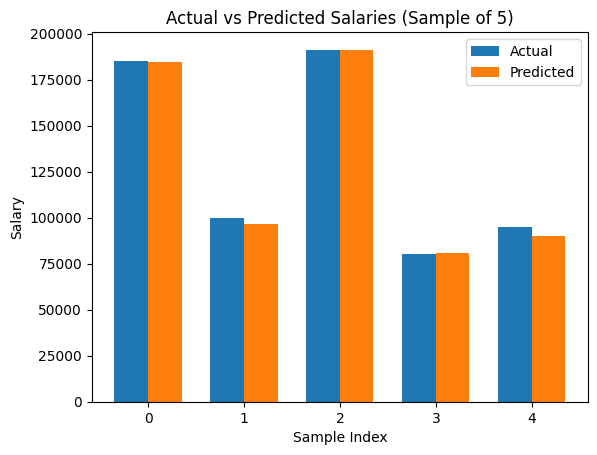

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Actual vs Predicted for the sample
labels = np.arange(len(y_actual))  # index positions
width = 0.35

plt.bar(labels - width/2, y_actual, width, label="Actual")
plt.bar(labels + width/2, y_pred, width, label="Predicted")

plt.xlabel("Sample Index")
plt.ylabel("Salary")
plt.title("Actual vs Predicted Salaries (Sample of 5)")
plt.legend()
plt.show()
plt.savefig("Actual vs Predicted Salaries.png")

## **Saving Best Fit Model**

In [15]:
import joblib
joblib.dump(best_model, "salary_prediction_model.pkl")

['salary_prediction_model.pkl']

## **Turn Model to a Function**

In [16]:
model = joblib.load("salary_prediction_model.pkl")

feature_names = ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience']

def predict_salary(Age, Gender, Edu_Level, Job_Title, Years_Exp):
    input_data = pd.DataFrame([{
        "Age": Age,
        "Gender": Gender,
        "Education Level": Edu_Level,
        "Job Title": Job_Title,
        "Years of Experience": Years_Exp
    }])

    prediction = model.predict(input_data)[0]  
    return prediction


salary = predict_salary(Age=30, Gender="Male", Edu_Level="PhD", Job_Title="Data Scientist", Years_Exp=20)
print(f"Predicted salary: {salary:.2f}")

Predicted salary: 172227.84
